## Time Series Regression Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn import linear_model

In [16]:
import statsmodels.api as sm

In [ ]:
#parse datetime with weird timezone format
def parse_datetime_with_timezone(dt_str):
    datetime_str = dt_str[:-3] + dt_str[-2:]
    return pd.to_datetime(datetime_str, utc=True, format="%Y-%m-%d %H:%M:%S%z")

# TODO RE-Write without using "date_parser"
df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')

# TODO Make sure this is the right timezone 
df.index = df.index.tz_convert('America/New_York')

#Set the frequency
#we need to do this before using in STL 
df= df.asfreq(freq='h')

In [3]:
df.drop(columns=["KCPLIATANUNIAT2","KCPLLACYGNEUNLAC2","SECI.KCPS.CIMARRON", "WR.LEC.4", "WR.JEC.2", "WR.JEC.3", "SECI.KCPS.CIMARRON"], 
        inplace=True)

### Set Up the Data

In [ ]:
#let's do regression on one price node
cimarron=df[["SECI_CIMARRON"]]

#Get the weather data
weather = pd.read_csv("CimarronWeather23.csv")
cimarron["temp"]=weather["temperature"].values
cimarron["wind"]=weather["wind_speed"].values

#Hold back the last week as the final test set
cimarron_train = cimarron.iloc[:-168]
cimarron_test = cimarron.iloc[-168:]
X=cimarron_train.drop("SECI_CIMARRON", axis="columns")
y=cimarron_train.drop(["temp", "wind"], axis="columns")

#Add constant column for regression
X = sm.add_constant(X)

Text(0.5, 1.0, 'November Node Price, Temp, WindSpeed')

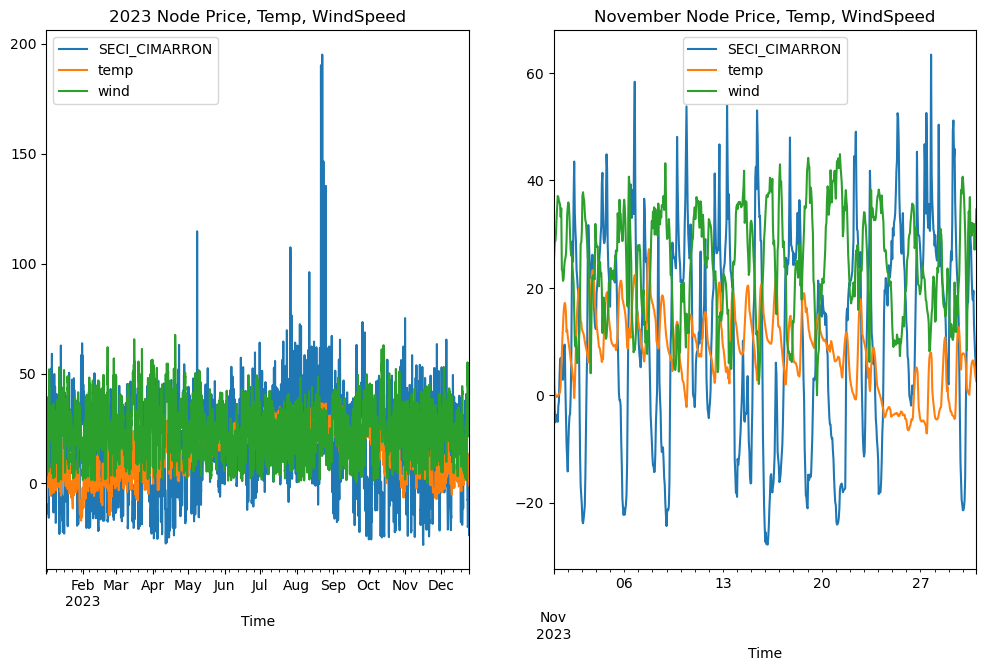

In [13]:
#Quick visualization to see any relation between features and price
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,7))
cimarron_train.plot(ax=ax1)
cimarron.loc["2023-11"].plot(ax=ax2)
ax1.set_title("2023 Node Price, Temp, WindSpeed")
ax2.set_title("November Node Price, Temp, WindSpeed")

### Basic OLS
Let's try it in SciKitLearn first

In [13]:
#set up cross validation splits
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=6500,
    test_size=500,
)

In [ ]:
ols = linear_model.LinearRegression(fit_intercept=False)
cv_results = cross_validate(ols, X, y, cv=ts_cv, 
                            scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"], 
                            return_estimator=True) 

In [19]:
mae = -cv_results["test_neg_mean_absolute_error"]
rmse = -cv_results["test_neg_root_mean_squared_error"]
r2 = cv_results["test_r2"]
print(
    f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
    f"R Squared: {r2.mean():.3f} +/- {rmse.std():.3f}")

Mean Absolute Error:     12.160 +/- 1.099
Root Mean Squared Error: 15.146 +/- 1.258
R Squared: 0.363 +/- 1.258


In [20]:
for reg in cv_results["estimator"]:
    print (reg.coef_)

[[38.8200968   0.36381389 -1.09662218]]
[[38.79938263  0.33810403 -1.09517704]]
[[38.59089688  0.34508407 -1.11853572]]
[[37.06399075  0.40241042 -1.11781534]]
[[38.80949697  0.35357329 -1.14724296]]


Now we do it in StatsModels

In [16]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          SECI_CIMARRON   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     3065.
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:24:41   Log-Likelihood:                -35562.
No. Observations:                8592   AIC:                         7.113e+04
Df Residuals:                    8589   BIC:                         7.115e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6287      0.459     88.438      0.0

#### Fitted Values

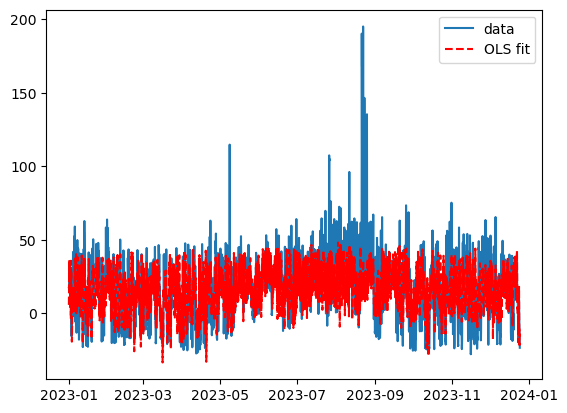

In [29]:
fig,ax=plt.subplots()
ax.plot(y, label='data')
ax.plot(results.fittedvalues, "r--", label="OLS fit")
ax.legend(loc='best')

In [40]:
compdf = y
compdf.reset_index(drop=True,inplace=True)
compdf['Fitted']=results.fittedvalues.values
sns.scatterplot(data = compdf, x="SECI_CIMARRON", y="Fitted")
plt.gca().axline((0, 0), slope=1, color='red', linestyle='--')
plt.show()

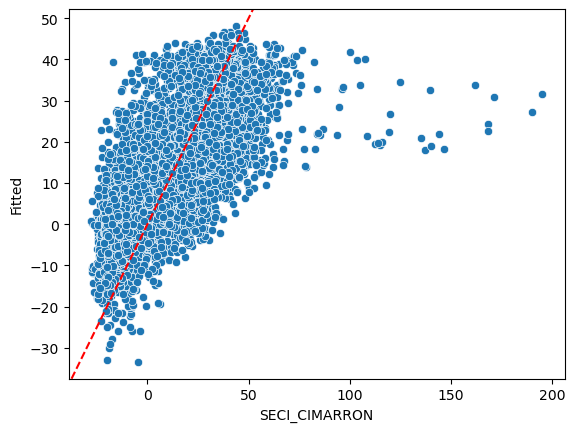

* R2 squared valued is .41, so the model caputres less than half of the variance in the data
* fitted values show how the model is limited in capturing the high variance price
* This model is not good at all, but this is more of an excercise in setting the model up and understanding the scores
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

### Evaluating The Regression Model

<Axes: xlabel='Time'>

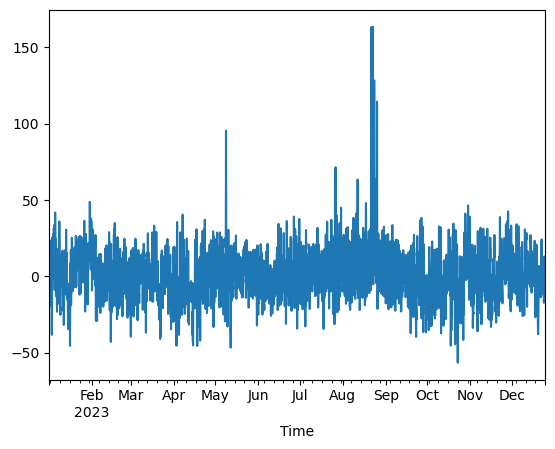

In [17]:
#Plot Residuals
results.resid.plot()

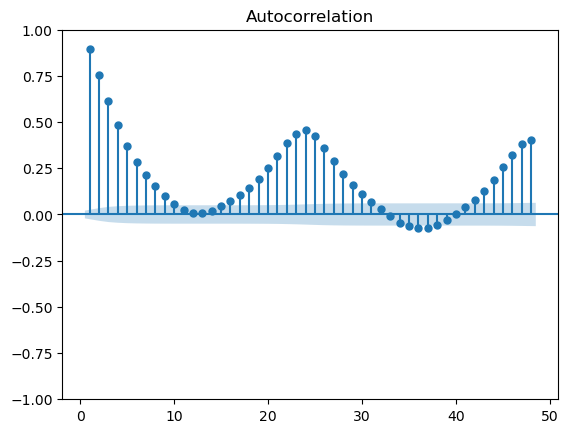

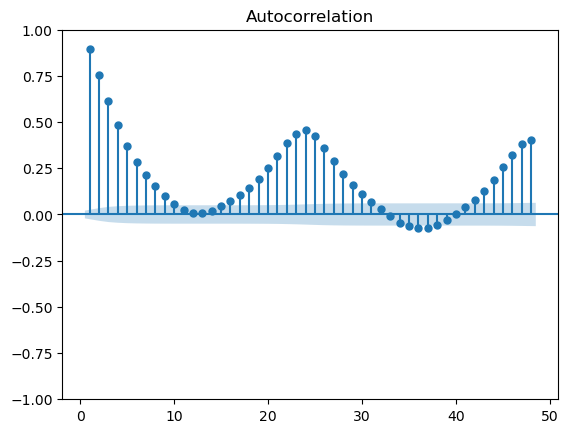

In [21]:
#ACF Plot of Residuals
sm.graphics.tsa.plot_acf(results.resid, zero=False, lags=48)

Strong autocorrelatoin of the residuals indicatse that are model is inefficient and there is more informatoin which should be captured

<Axes: ylabel='Count'>

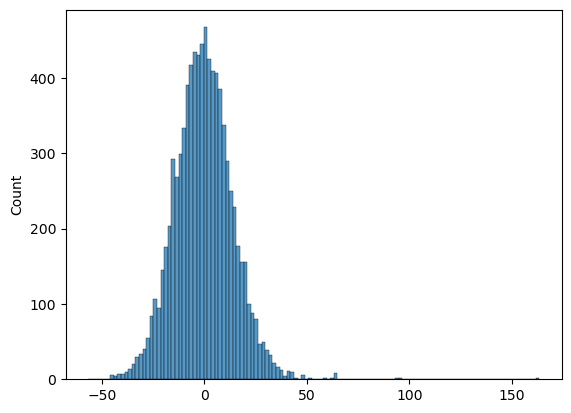

In [23]:
sns.histplot(results.resid)

In [24]:
cimarron_res = cimarron_train

In [28]:
cimarron_res["fitted"]=results.fittedvalues.values
cimarron_res["resid"]=results.resid.values
cimarron_res.head()

C:\Users\U1231034\AppData\Local\Temp\ipykernel_24224\3034282725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron_res["fitted"]=results.fittedvalues.values
C:\Users\U1231034\AppData\Local\Temp\ipykernel_24224\3034282725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron_res["resid"]=results.resid.values


,SECI_CIMARRON,temp,wind,fitted,resid
Time,,,,,
2023-01-01 01:00:00-05:00,17.3592,4.4,31.3,5.755060,11.604140
2023-01-01 02:00:00-05:00,17.1675,3.5,28.7,8.522165,8.645335
2023-01-01 03:00:00-05:00,18.5753,2.6,25.7,11.748589,6.826711
2023-01-01 04:00:00-05:00,18.0899,3.1,28.7,8.425067,9.664833
2023-01-01 05:00:00-05:00,18.7861,3.1,28.9,8.195407,10.590693


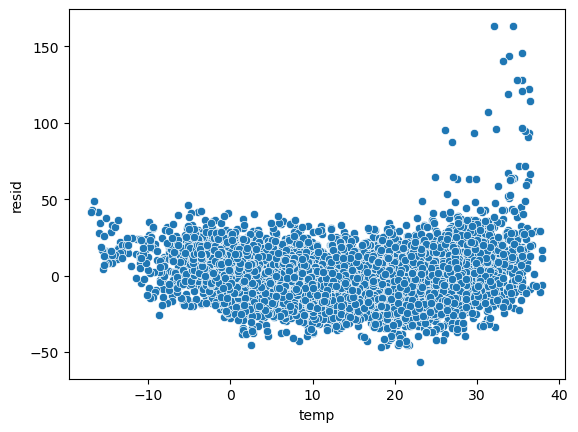

In [31]:
sns.scatterplot(data = cimarron_res, x="temp", y="resid")
plt.show()

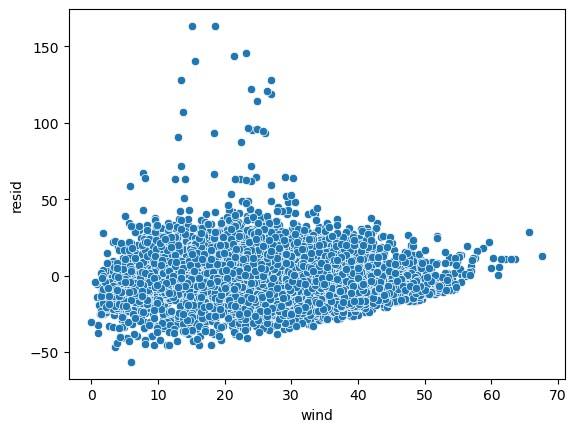

In [32]:
sns.scatterplot(data = cimarron_res, x="wind", y="resid")
plt.show()

Residuals plotted against the predictors look to be unrandom. The plots do show a pttern and the relatoinship maybe nonlinear. we should try a transformatoin or a nonlinear regression

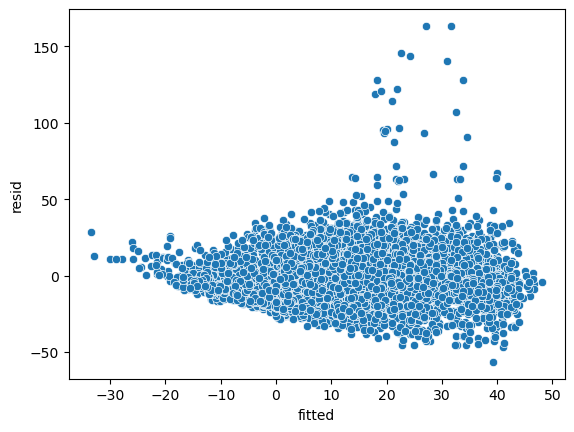

In [33]:
#HETERSCEDASTICITY
sns.scatterplot(data = cimarron_res, x="fitted", y="resid")
plt.show()

the varinace clearly increases and shows strong heteroscedasticty

### Predictors

#### Seasonal Dummy variables- Day of the Week

In [12]:
cimarron_train.head()

,SECI_CIMARRON,temp,wind
Time,,,
2023-01-01 01:00:00-05:00,17.3592,4.4,31.3
2023-01-01 02:00:00-05:00,17.1675,3.5,28.7
2023-01-01 03:00:00-05:00,18.5753,2.6,25.7
2023-01-01 04:00:00-05:00,18.0899,3.1,28.7
2023-01-01 05:00:00-05:00,18.7861,3.1,28.9


In [13]:
cimarron_train["DayofWeek"]=cimarron_train.index.dayofweek
cimarron_train.head()

/var/folders/n9/fmlq1lnj2f7d297hfrdwxdb80000gn/T/ipykernel_9712/1606966592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron_train["DayofWeek"]=cimarron_train.index.dayofweek


,SECI_CIMARRON,temp,wind,DayofWeek
Time,,,,
2023-01-01 01:00:00-05:00,17.3592,4.4,31.3,6
2023-01-01 02:00:00-05:00,17.1675,3.5,28.7,6
2023-01-01 03:00:00-05:00,18.5753,2.6,25.7,6
2023-01-01 04:00:00-05:00,18.0899,3.1,28.7,6
2023-01-01 05:00:00-05:00,18.7861,3.1,28.9,6


In [12]:
#make a pipline for the one hot encoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [15]:
X=cimarron_train.drop("SECI_CIMARRON", axis="columns")
X = sm.add_constant(X)

In [29]:
# wan to encode n_cat-1 so we use "drop"
column_trans = ColumnTransformer(
    [('DoW', OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop= 'first'), ['DayofWeek'])],
    remainder='passthrough')
# use ColumnTransformer to only transform the DayofWeek Column

In [30]:
X_trans = column_trans.fit_transform(X)

In [32]:
X_trans[:30]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  4.4, 31.3],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  3.5, 28.7],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  2.6, 25.7],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  3.1, 28.7],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  3.1, 28.9],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  0.8,  9.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  0.9,  4.7],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. , -0.6,  8. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. , -0.2, 13.3],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  0.4,  3.7],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. , -0.2, 10.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  1.2, 16.6],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  3.1, 21. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  5.1, 15.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  6.6, 14.3],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  7.4,

In [30]:
X_trans.shape

(8592, 9)

In [16]:
y=cimarron_train.drop(["temp", "wind", "DayofWeek"], axis="columns")
y.head()

,SECI_CIMARRON
Time,
2023-01-01 01:00:00-05:00,17.3592
2023-01-01 02:00:00-05:00,17.1675
2023-01-01 03:00:00-05:00,18.5753
2023-01-01 04:00:00-05:00,18.0899
2023-01-01 05:00:00-05:00,18.7861


In [17]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop= 'first')
ols = linear_model.LinearRegression(fit_intercept=False)

linear_pipeline=make_pipeline(
    ColumnTransformer(
        [('DoW', OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop= 'first'), ['DayofWeek'])],
        remainder='passthrough',
    ),
    ols,
)

In [18]:
cv_results2 = cross_validate(linear_pipeline, X, y, cv=ts_cv, scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"], return_estimator=True) 

In [19]:
mae = -cv_results2["test_neg_mean_absolute_error"]
rmse = -cv_results2["test_neg_root_mean_squared_error"]
r2 = cv_results2["test_r2"]
print(
    f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
    f"R Squared: {r2.mean():.3f} +/- {rmse.std():.3f}")

Mean Absolute Error:     12.181 +/- 1.099
Root Mean Squared Error: 15.147 +/- 1.268
R Squared: 0.363 +/- 1.268


In [ ]:
"""
Original Results w/o dummy
Mean Absolute Error:     12.160 +/- 1.099
Root Mean Squared Error: 15.146 +/- 1.258
R Squared: 0.363 +/- 1.258
"""

Let's check the coefficients on one of the estimators

In [28]:
pipe = cv_results2['estimator'][0]
pipe.named_steps['linearregression'].coef_

array([[-1.97916443, -1.04265547,  0.71802774, -0.21776105, -3.30729949,
        -3.32712932, 40.28106137,  0.36309079, -1.10253567]])

In [ ]:
"""
Original Results w/o dummy
[[38.8200968   0.36381389 -1.09662218]]
[[38.79938263  0.33810403 -1.09517704]]
[[38.59089688  0.34508407 -1.11853572]]
[[37.06399075  0.40241042 -1.11781534]]
[[38.80949697  0.35357329 -1.14724296]]
"""

The incercept and the coefficients for wind and temperature at the same for what we got w/0 with dummies
unfortunatlity this the dummys don't capture anymore infromatoin that without

### Dummy variables for the months

In [10]:
cimarron_train.head()

,SECI_CIMARRON,temp,wind
Time,,,
2023-01-01 01:00:00-05:00,17.3592,4.4,31.3
2023-01-01 02:00:00-05:00,17.1675,3.5,28.7
2023-01-01 03:00:00-05:00,18.5753,2.6,25.7
2023-01-01 04:00:00-05:00,18.0899,3.1,28.7
2023-01-01 05:00:00-05:00,18.7861,3.1,28.9


In [11]:
cimarron_train["Month"]=cimarron_train.index.month
cimarron_train.head()

/var/folders/n9/fmlq1lnj2f7d297hfrdwxdb80000gn/T/ipykernel_34078/4114025390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron_train["Month"]=cimarron_train.index.month


,SECI_CIMARRON,temp,wind,Month
Time,,,,
2023-01-01 01:00:00-05:00,17.3592,4.4,31.3,1
2023-01-01 02:00:00-05:00,17.1675,3.5,28.7,1
2023-01-01 03:00:00-05:00,18.5753,2.6,25.7,1
2023-01-01 04:00:00-05:00,18.0899,3.1,28.7,1
2023-01-01 05:00:00-05:00,18.7861,3.1,28.9,1


In [14]:
X=cimarron_train.drop("SECI_CIMARRON", axis="columns")
X = sm.add_constant(X)

In [21]:
X.head()

,const,temp,wind,Month
Time,,,,
2023-01-01 01:00:00-05:00,1.0,4.4,31.3,1
2023-01-01 02:00:00-05:00,1.0,3.5,28.7,1
2023-01-01 03:00:00-05:00,1.0,2.6,25.7,1
2023-01-01 04:00:00-05:00,1.0,3.1,28.7,1
2023-01-01 05:00:00-05:00,1.0,3.1,28.9,1


In [15]:
y=cimarron_train.drop(["temp", "wind", "Month"], axis="columns")
y.head()

,SECI_CIMARRON
Time,
2023-01-01 01:00:00-05:00,17.3592
2023-01-01 02:00:00-05:00,17.1675
2023-01-01 03:00:00-05:00,18.5753
2023-01-01 04:00:00-05:00,18.0899
2023-01-01 05:00:00-05:00,18.7861


In [34]:
#Check the Transformer
# wan to encode n_cat-1 so we use "drop"
column_trans = ColumnTransformer(
    [('Month', OneHotEncoder(sparse_output=False, drop= 'first'), ['Month'])],
    remainder='passthrough')
# use ColumnTransformer to only transform the DayofWeek Column

In [35]:
X_trans = column_trans.fit_transform(X)

In [31]:
X_trans[-1:]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,
         1. , -0.9, 48.7]])

In [32]:
#one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop= 'first')
ols = linear_model.LinearRegression(fit_intercept=False)

linear_pipeline_month=make_pipeline(
    ColumnTransformer(
        [('Month', OneHotEncoder(sparse_output=False, drop= 'first'), ['Month'])],
    remainder='passthrough',
    ),
    ols,
)

In [ ]:
cv_results3 = cross_validate(linear_pipeline_month, X, y, cv=ts_cv, 
                             scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"], return_estimator=True) 

running into an issue with the one hot encoding when splitting the data. the split between train and test might not see that same months so there will be unknown encoders between them. I could try and find a different approach but Ill move on for now. 

In [25]:
mae = -cv_results3["test_neg_mean_absolute_error"]
rmse = -cv_results3["test_neg_root_mean_squared_error"]
r2 = cv_results3["test_r2"]
print(
    f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
    f"R Squared: {r2.mean():.3f} +/- {rmse.std():.3f}")

Mean Absolute Error:     11.699 +/- 1.081
Root Mean Squared Error: 14.649 +/- 1.271
R Squared: 0.402 +/- 1.271


In [ ]:
"""
Original Results w/o dummy
Mean Absolute Error:     12.160 +/- 1.099
Root Mean Squared Error: 15.146 +/- 1.258
R Squared: 0.363 +/- 1.258
"""

Let's check the coefficients on one of the estimators

In [26]:
pipe = cv_results3['estimator'][0]
pipe.named_steps['linearregression'].coef_

array([[-4.84160860e+00, -3.57302448e+00, -5.19197688e+00,
         4.62906519e+00,  3.53278883e+00,  9.11408209e+00,
         1.44190764e+01,  5.48766921e+00,  4.00220249e+01,
        -3.26335115e-02, -1.00751270e+00]])

In [ ]:
"""
Original Results w/o dummy
[[38.8200968   0.36381389 -1.09662218]]
[[38.79938263  0.33810403 -1.09517704]]
[[38.59089688  0.34508407 -1.11853572]]
[[37.06399075  0.40241042 -1.11781534]]
[[38.80949697  0.35357329 -1.14724296]]
"""

### TODO Fourier Features (Harmonic Regression)

transform data using fft to find the main frequecies then use the inverse transform to find the functions for those peak frequencies, create features from those functoins to use in regression

https://towardsdatascience.com/how-to-add-fourier-terms-to-your-regression-seasonality-analysis-using-python-scipy-99a94d3ae51

### TODO Forecasting with Regression

### General Workflow
* pre-process data: pipeline
* split data into training and test set: pandas slicing
* set up cross validation on train set: TimeSeriesSplit
* Model tuning and evaluation: cross_validate
* ?Evaluate model on test set?

In [ ]:
# Ordinary Least Squares
# https://scikit-learn.org/stable/modules/linear_model.html